**Index Simple Data Files With The Fast Feedback Indexer**

(hans-christian.stadler@psi.ch)

In [1]:
import os
import sys
import os.path
import numpy as np
import matplotlib.pyplot as plt

In order to import the fast-feedback-indexer python module
- the system environment has to be setup correctly. This can be done by sourcing the setup-env.sh scipt that comes with the fast-feedback-indexer, or via the spack module, or manually.
- the fast-feedback-indexer cmake compilation needs to be setup to produce the python module.

A qick and dirty test is to see if your PYTHONPATH points to the fast-feedback-indexer python module:

In [2]:
if any(["ffbidx" in path for path in sys.path]):
    print("OK: ffbidx is in your python module search path")
else:
    print("WARNING: ffbidx is NOT in your python module search path")

OK: ffbidx is in your python module search path


In [3]:
# set python module log level (fatal, error, warn, info, debug) and import fast-feedback-indexer python module
os.environ["INDEXER_LOG_LEVEL"] = "info"

import ffbidx

Simple data files are described [here](https://github.com/paulscherrerinstitute/fast-feedback-indexer/tree/main/data/simple), and the files this notebook uses are [here](https://github.com/paulscherrerinstitute/fast-feedback-indexer/tree/main/data/simple). If you have cloned the fast-feedback-indexer repository and execute this notebook directly from its repository folder, the path below should be correct. Otherwise please adapt the notebook. A quick and dirty check is to see if one of the expected files is present.



In [4]:
simple_data_file_dir = "../../data/simple/files"

if os.path.exists(os.path.join(simple_data_file_dir, "image0_local.txt")):
    print("OK: simple data file directory seems to be OK")
else:
    print("WARNING: simple data file directory doesn't look OK")

OK: simple data file directory seems to be OK


There are 10 simple data files in the repository, numbered 0 to 9. Each of them is present in 3 version: local, peakfinder8, radial. The versions refer to the method that produced the spots.

Choose a file/version:

In [5]:
file_number = 0
file_version = "peakfinder8"

file_path = os.path.join(simple_data_file_dir, f"image{file_number}_{file_version}.txt")
if os.path.exists(file_path):
    print("OK")
else:
    print("WARNING: file/version doesn't exist")

OK


Read the simple data file. There should be one input cell in real space and some spots in reciprocal space. Some lines could be comments starting with \#.

In [6]:
coords = []
with open(file_path, "r") as f:
    for line in f.readlines():
        try:
            coords += [float(x) for x in line.split()]
        except:
            pass

For the fast-feedback-indexer, input data has to be in float32 column major (Fortran) memory order. There should be a multiple of 3 coordinate pairs, as the cell and spot vectors are in 3D.

In [7]:
input_data = np.asarray(np.array(coords).reshape(-1, 3), dtype='float32', order='F')

if input_data.shape[0] < 4:
    print("WARNING: data looks bad")

print(input_data.shape, input_data.dtype)
print(input_data.flags)

(866, 3) float32
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



First and only input cell in real space:

In [8]:
input_cell = np.asarray(input_data[:3,:], dtype='float32', order='F')
input_cell

array([[3.69000e+01, 0.00000e+00, 0.00000e+00],
       [4.83429e-15, 7.89500e+01, 0.00000e+00],
       [4.83429e-15, 4.83429e-15, 7.89500e+01]], dtype=float32)

First spot in reciprocal space:

In [9]:
spots = np.asarray(input_data[3:,:], dtype='float32', order='F')
spots[0,:]

array([-0.0328844, -0.723767 , -0.31074  ], dtype=float32)

Create an indexer object. This will return a handle to the object (sorry for the not so python-like interface). Check the description of [ffbidx.indexer()](https://github.com/paulscherrerinstitute/fast-feedback-indexer/tree/main/python). Her the argumets are:
1) 32 output cells
2) 1 input cell
3) the 300 first are considered, or less if there aren't that many
4) 32 candidate vectors: the algorithms single vector brute force sampling step takes the 32 best vectors and computes the 32 best cells using these vectors as rotation axes.

The GPU device is set via the INDEXER_GPU_DEVICE environment variable. This call allocates memory on the GPU device.

In [10]:
os.environ["INDEXER_GPU_DEVICE"] = "0"
h = ffbidx.indexer(32, 1, 300, 32)

(info) using GPU device 0


Now you can index input data using [ffbidx.index()](https://github.com/paulscherrerinstitute/fast-feedback-indexer/tree/main/python). This function can be called several times, of course. E.g. for every frame to be indexed. The arguments are:
1) indexer object handle
2) spots in reciprocal space
3) input cells in real space
4) refinement method
5) vector length threshold: vectors are considered to be of the same length if the length differs by less than this threshold
6) lower trim value for scoring (look at the description in the repo)
7) higher trim value for scoring (look at description)
8) delta value for scoring (look at description)
9) number of sampling points on the half sphere
10) number of output cells (can be less than reserved for in the ffbidx.indexer() call)
11) refinement threshold contraction factor (to be described, lsq refinment to spots approximated within a contracting threshold)
12) refinement minimum number of spots (to be described, quit refinement if there are less spots within the threshold)
13) refinement maximum number of iterations (to be described, quit refinement if the number of refinement iterations has reached this)

This returns the 32 best cells found together with scores (worst error among the best minimum number of spots). The cells are returned as a C array, but in column mayor (Fortran) order.

In [11]:
%time cells, scores = ffbidx.index(h, spots, input_cell, "ifss", 1e-9, .05, .3, .1, 32*1024, 32, .8, 6, 15)
print("cells", cells.shape, cells.dtype)
print(cells.flags)
print(cells)
print("scores", scores.shape, scores.dtype)
print(scores)

CPU times: user 12.2 ms, sys: 383 µs, total: 12.6 ms
Wall time: 12.6 ms
cells (3, 96) float32
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

[[ 28.901472  -28.184898  -39.431408  -28.901472  -28.184898   39.431408
   28.923906   39.470116  -28.170324  -28.923906   39.470116   28.170324
   28.916422  -28.186462  -39.419518  -28.916422  -28.186462   39.419518
   28.910732   39.42312   -28.194351  -28.910732   39.42312    28.194351
   28.902771   39.42448   -28.18762   -28.902771   39.42448    28.18762
   28.911707  -28.183792  -39.424805  -28.911707  -28.183792   39.424805
   28.90025    39.42605   -28.193424  -28.90025    39.42605    28.193424
   28.89505    39.42716   -28.19778   -28.89505    39.42716    28.19778
   28.913734   39.424362  -28.186214  -28.913734   39.424362   28.186214
   28.940584   39.518944  -30.25771   -28.940584   39.518944   30.25771
   28.931187  -28.232695  -41.11347   -28.931187  -28.

(info) indexing_time: 0.995333ms
(info) kernel_time: 0.896736ms


Release the indexer object and associated resources on the GPU device. After that the handle is invalid.

In [12]:
ffbidx.release(h)

Look at the best cell now:

In [13]:
i = np.argmin(scores)
print("best score is", scores[i])
cell = cells[:, 3*i:3*i+3]
cell

best score is 0.0075741136


array([[ 28.923906,  39.470116, -28.170324],
       [-20.34701 ,  25.008518, -60.442772],
       [-10.257495,  62.95947 ,  41.081017]], dtype=float32)

Function to show some info for a lattice base B:

In [14]:
def cell_info(B, **args):
    return dict({
        'det': np.linalg.det(B),
        'vlen': np.linalg.norm(B, axis=0),
        'angle': [np.rad2deg(np.arccos(np.dot(B[:, i], B[:, (i+1)%3]) / (np.linalg.norm(B[:, i]) * np.linalg.norm(B[:, (i+1)%3])))) for i in range(3)]
    }, **args)


In [15]:
print(cell_info(input_cell, cell="input"))
print(cell_info(cell, cell="best"))

{'det': 230001.47, 'vlen': array([36.9 , 78.95, 78.95], dtype=float32), 'angle': [90.0, 90.0, 90.0], 'cell': 'input'}
{'det': 226108.12, 'vlen': array([36.821316, 78.40415 , 78.32334 ], dtype=float32), 'angle': [90.2585, 90.34551, 90.12624], 'cell': 'best'}


Function to plot some error statistics.

In [16]:
def plot_error(B, S, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
    C = S @ B
    Z = C.round()
    e = np.linalg.norm(C - Z, axis=1)
    ax[0].plot(e)
    ax[0].set_xlabel('spot')
    ax[0].set_ylabel('error')
    _ = ax[1].hist(e, bins=50)
    ax[1].set_xlabel('error')
    ax[1].set_ylabel('number of spots')
    _ = ax[2].hist(e, bins=50, cumulative=True, histtype='step')
    ax[2].set_xlabel('error')
    ax[2].set_ylabel('number of spots')
    ax[1].set_title(title)
    plt.tight_layout()

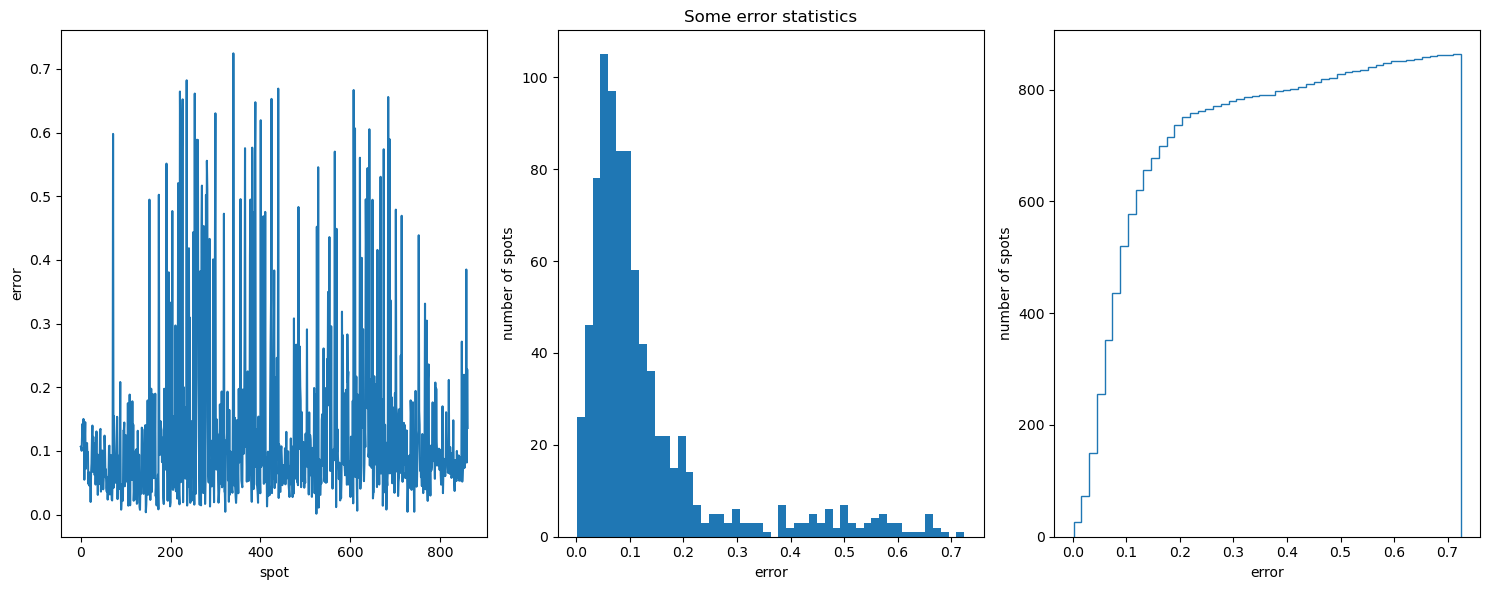

In [17]:
plot_error(cell, spots, "Some error statistics")